In [1]:
# importing all the libraries needed 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
sns.set_style("whitegrid")
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error

#For date time functions
from datetime import datetime
from datetime import timedelta
import math

# Importing the most popular regression libraries.
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, ridge_regression, Lasso, SGDRegressor, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
train = './data/train_data.csv'
test = './data/test_data.csv'


df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

df_train = df_train.sort_values(by = ['id','mes'])
df_test = df_test.sort_values(by = ['id','mes'])



In [4]:
# Dataset de Train y Test con los mismos Id

df_testnotintrain = df_test[~(df_test['id'].isin(df_train['id']) )].reset_index(drop=True)
print(len(df_testnotintrain.id.unique()))

newtest = df_test[df_test['id'].isin(df_testnotintrain.id.unique()) == False]

df_trainnotintest = df_train[~(df_train['id'].isin(df_test['id']) )].reset_index(drop=True)
print(len(df_trainnotintest.id.unique()))

newtrain = df_train[df_train['id'].isin(df_trainnotintest.id.unique()) == False]

custX = newtrain.id.unique()
custY = newtest.id.unique()
print(len(custX))
print(len(custY))


11226
11288
21504
21504


In [5]:
df_train=newtrain.sort_values(by = ['id','mes'])
df_test=newtest.sort_values(by = ['id','mes'])

In [6]:
# Form Date, Year, Month, Week, Day
def split(data):
    data['Date'] = pd.to_datetime(data['mes'],format='%Y%m')
    data['Year'] = data['Date'].dt.year
    data['Month']= data['Date'].dt.month
    return data

df_train=split(df_train)
df_test=split(df_test)

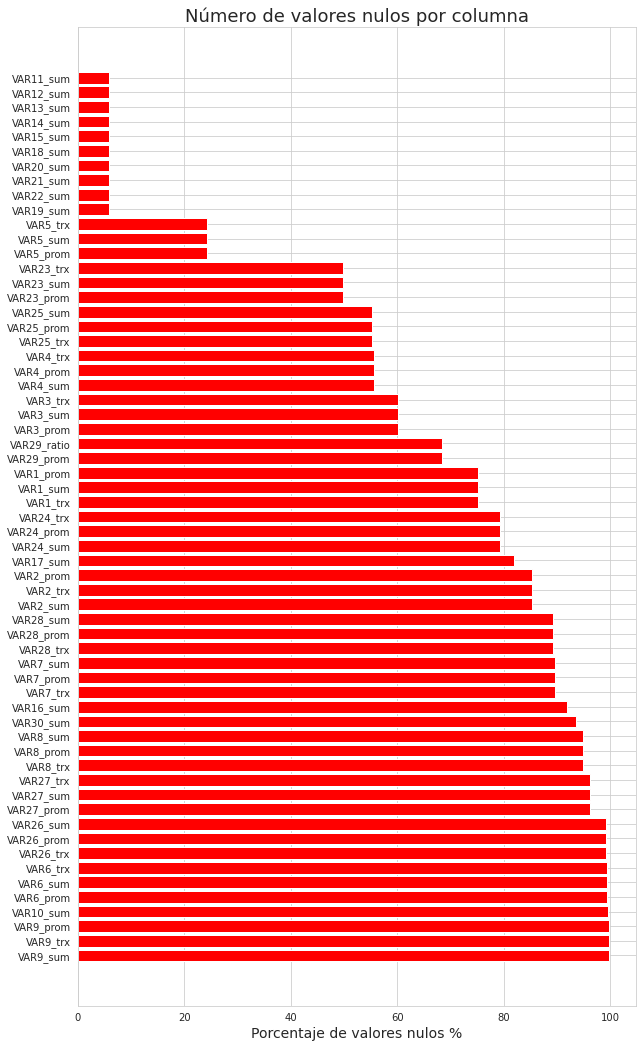

In [7]:
# Porcentaje de valores nulos x columna

missing = df_train.isnull().sum(0).reset_index()
missing.columns = ['column', 'count']
missing = missing.sort_values(by = 'count', ascending = False).loc[missing['count'] > 0]
missing['percentage'] = missing['count'] / float(df_train.shape[0]) * 100
ind = np.arange(missing.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, missing.percentage.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(missing.column.values, rotation='horizontal')
ax.set_xlabel("Porcentaje de valores nulos %", fontsize = 14)
ax.set_title("Número de valores nulos por columna", fontsize = 18)
plt.show()

In [8]:
# Borramos todas las variables con un porcentaje de nulos mayor al 20%

delete_col = missing.loc[missing['percentage'] >= 20].column.values
train_set = df_train.drop(delete_col, axis=1)
test_set = df_test.drop(delete_col,axis=1)

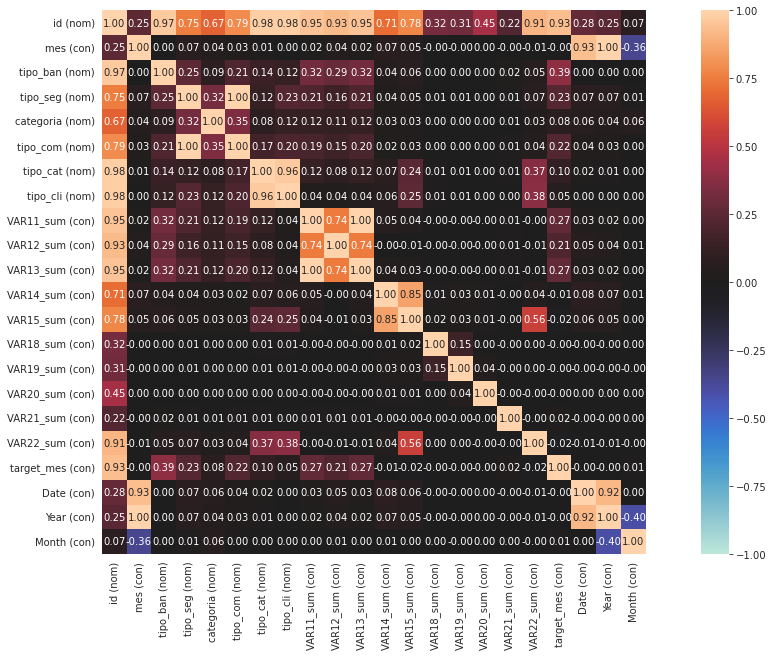

In [10]:
from dython import nominal 


# Matriz de Correlaciones

assoc = nominal.associations(train_set ,figsize=(20,10),mark_columns=True, plot = False)
correlations = assoc['corr']


In [11]:
# Vamos a trabajar sólo con las variables que tengan una correlación mayor o igual al 10% con la variable objetivo

candidates = abs(correlations[correlations['target_mes (con)']>=.10]['target_mes (con)']).sort_values(ascending=False)
candidates

target_mes (con)    1.000000
id (nom)            0.931842
tipo_ban (nom)      0.389673
VAR13_sum (con)     0.268286
VAR11_sum (con)     0.267852
tipo_seg (nom)      0.233883
tipo_com (nom)      0.222359
VAR12_sum (con)     0.213238
tipo_cat (nom)      0.103712
Name: target_mes (con), dtype: float64

In [12]:
varsX = ['id','tipo_ban', 'VAR13_sum', 'VAR11_sum', 'tipo_seg', 'tipo_com', 'VAR12_sum', 'tipo_cat','target_mes','mes']
varsy = ['id','tipo_ban', 'VAR13_sum', 'VAR11_sum', 'tipo_seg', 'tipo_com', 'VAR12_sum', 'tipo_cat','mes']
vary =  ['target_mes']

In [13]:
df_train=train_set[varsX]
df_tesx= test_set[varsy]




In [14]:
from sklearn import model_selection, preprocessing

# Recodificamos los valores categóricos

def labelrecoded(df):
    for f in df.columns:
        if df[f].dtype=='object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(df[f].values)) 
            df[f] = lbl.transform(list(df[f].values))
    return df

In [15]:
df_train = labelrecoded(df_train)
df_tesx = labelrecoded(df_tesx)

In [16]:
#X = df_train[['id','categoria',  'tipo_seg',  'tipo_ban',  'tipo_com', 'tipo_cat',  'tipo_cli', 
#                    'VAR21_sum',  'VAR22_sum',  'VAR14_sum',  'VAR15_sum',  'VAR12_sum', 'VAR11_sum','log_price']]
#y = df_train['log_price']

X = df_train
y = df_train['target_mes']



In [17]:
# Completamos los valores nulos con 0. Acá hay un punto de mejora

X['VAR13_sum'] = X['VAR13_sum'].fillna(0)
X['VAR12_sum'] = X['VAR12_sum'].fillna(0)
X['VAR11_sum'] = X['VAR11_sum'].fillna(0)

df_tesx['VAR13_sum'] = df_tesx['VAR13_sum'].fillna(0)
df_tesx['VAR12_sum'] = df_tesx['VAR12_sum'].fillna(0)
df_tesx['VAR11_sum'] = df_tesx['VAR11_sum'].fillna(0)


In [18]:
def rmse(y,yhat):
    return np.sqrt(np.sum((y - yhat) ** 2) / len(y)) 


In [19]:
def mae(y,yhat):
    return np.sum(np.absolute(y - yhat)) / len(y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # Train:Test = 70:30 splitting.

X_train_target = pd.DataFrame()
X_train_target['target_mes'] = X_train['target_mes']
X_train = X_train.drop(['target_mes'], axis = 1)

X_test_target = pd.DataFrame()
X_test_target['target_mes'] = X_test['target_mes']
X_test = X_test.drop(['target_mes'], axis = 1)

# Final shapes.
print('Train shape:', X_train.shape, y_train.shape)
print('Test shape: ', X_test.shape, y_test.shape)

Train shape: (368265, 9) (368265,)
Test shape:  (157829, 9) (157829,)


In [21]:
model_lr = LinearRegression(fit_intercept=True,normalize=True).fit(X_train,y_train)
y_pred_train_lr = model_lr.predict(X_train)
y_pred_test_lr = model_lr.predict(X_test)

print('Train shape :', X_train.shape, y_train.shape)
print("Stats")
print("Train RMSE : ", rmse( y_train, y_pred_train_lr))
print("Test RMSE :", rmse( y_test, y_pred_test_lr))
print("Train MAE : ", mae( y_train, y_pred_train_lr))
print("Test MAE :", mae(y_test, y_pred_test_lr))


Train shape : (368265, 9) (368265,)
Stats
Train RMSE :  975.0197290314255
Test RMSE : 956.9689634690368
Train MAE :  218.99605427611323
Test MAE : 219.2328813431101


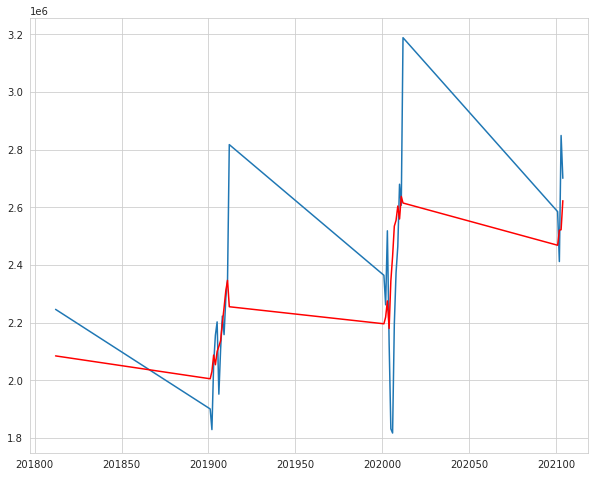

In [22]:
serie_original = pd.DataFrame()
serie_pred = pd.DataFrame()

#serie_original['id'] = X_train['id']
serie_original['mes'] =X_train['mes']
serie_original['target_mes'] = X_train_target['target_mes']

#serie_pred['id'] = df_train['id']
serie_pred['mes'] = X_train['mes']
serie_pred['target_mes'] = y_pred_train_lr

so = serie_original.groupby('mes')['target_mes'].sum()
sp = serie_pred.groupby('mes')['target_mes'].sum()

plt.figure(figsize=((10,8)))
plt.plot(so)
plt.plot(sp, color='red')
plt.show()

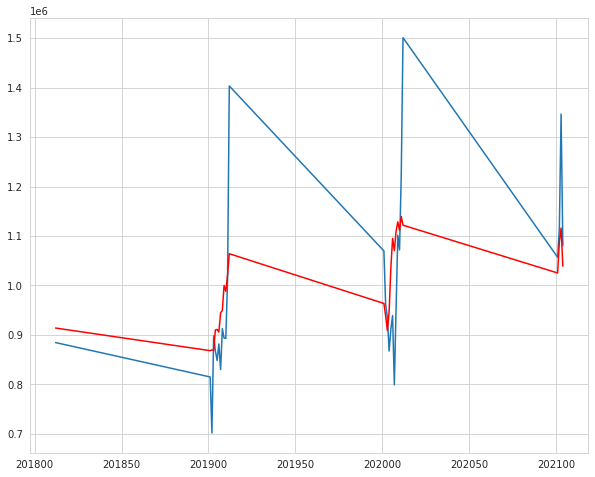

In [23]:
serie_original = pd.DataFrame()
serie_pred = pd.DataFrame()

#serie_original['id'] = X_train['id']
serie_original['mes'] = X_test['mes']
serie_original['target_mes'] =  X_test_target['target_mes']

serie_pred['mes'] = X_test['mes']
serie_pred['target_mes'] = y_pred_test_lr

so = serie_original.groupby('mes')['target_mes'].sum()
sp = serie_pred.groupby('mes')['target_mes'].sum()

plt.figure(figsize=((10,8)))
plt.plot(so)
plt.plot(sp, color='red')
plt.show()

In [24]:
from xgboost import XGBClassifier, XGBRegressor



lgb_Model = XGBRegressor(max_depth=27, n_estimators=100)
lgb_Model.fit(X_train,y_train)

y_pred_train_lr1 = lgb_Model.predict(X_train)
y_pred_test_lr1 = lgb_Model.predict(X_test)

print('Train shape :', X_train.shape, y_train.shape)
print("Log Stats")
print("Train RMSE : ", rmse( y_train, y_pred_train_lr1))
print("Test RMSE :", rmse( y_test, y_pred_test_lr1))
print("Train MAE : ", mae( y_train, y_pred_train_lr1))
print("Test MAE :", mae(y_test, y_pred_test_lr1))


Train shape : (368265, 9) (368265,)
Log Stats
Train RMSE :  0.8908472407625807
Test RMSE : 492.3972587084152
Train MAE :  0.3777791830820246
Test MAE : 74.67709310278153


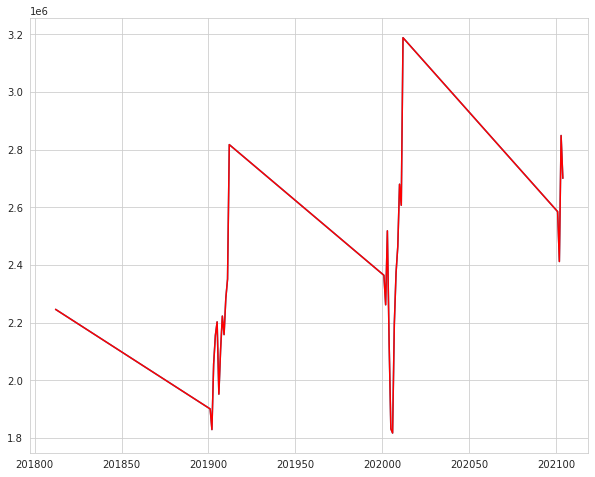

In [25]:
serie_original = pd.DataFrame()
serie_pred = pd.DataFrame()

#serie_original['id'] = X_train['id']
serie_original['mes'] = X_train['mes']
serie_original['target_mes'] = X_train_target['target_mes']

#serie_pred['id'] = df_train['id']
serie_pred['mes'] = X_train['mes']
serie_pred['target_mes'] = y_pred_train_lr1

so = serie_original.groupby('mes')['target_mes'].sum()
sp = serie_pred.groupby('mes')['target_mes'].sum()

plt.figure(figsize=((10,8)))
plt.plot(so)
plt.plot(sp, color='red')
plt.show()

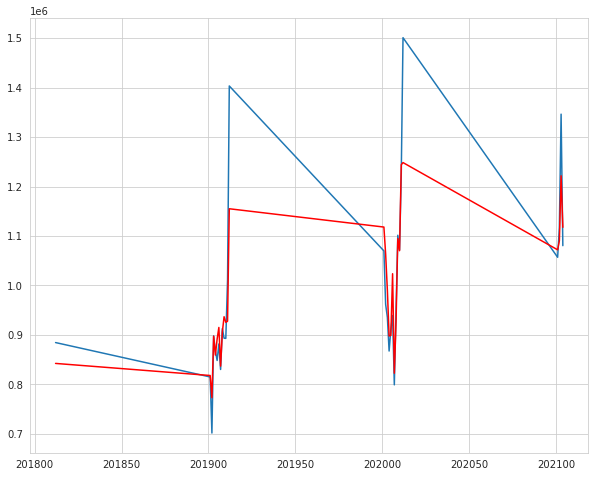

In [26]:
serie_original = pd.DataFrame()
serie_pred = pd.DataFrame()

#serie_original['id'] = X_train['id']
serie_original['mes'] = X_test['mes']
serie_original['target_mes'] = X_test_target['target_mes']

#serie_pred['id'] = df_train['id']
serie_pred['mes'] = X_test['mes'] 
serie_pred['target_mes'] = y_pred_test_lr1

so = serie_original.groupby('mes')['target_mes'].sum()
sp = serie_pred.groupby('mes')['target_mes'].sum()

plt.figure(figsize=((10,8)))
plt.plot(so)
plt.plot(sp, color='red')
plt.show()

In [27]:
X_train[X_train['id']==21489]

,id,tipo_ban,VAR13_sum,VAR11_sum,tipo_seg,tipo_com,VAR12_sum,tipo_cat,mes
608793,21489,0,157622651.0,157622651.0,6,2,0.0,15,201906
608099,21489,0,100337861.0,110136768.0,6,2,19808923.0,15,202101
608709,21489,0,161363870.0,161363870.0,6,2,0.0,15,201901
608500,21489,0,154869004.0,154869004.0,6,2,0.0,15,201909
607752,21489,0,161938343.0,171600238.0,6,2,20928450.0,15,202005
609065,21489,0,159176612.0,159176612.0,6,2,0.0,15,201903
608333,21489,0,160228474.0,160228474.0,6,2,0.0,15,201902
608924,21489,0,158593017.0,158593017.0,6,2,0.0,15,201904
608149,21489,0,98488741.0,108378838.0,6,2,18844264.0,15,202103
608418,21489,0,149987453.0,149987453.0,6,2,0.0,15,202003


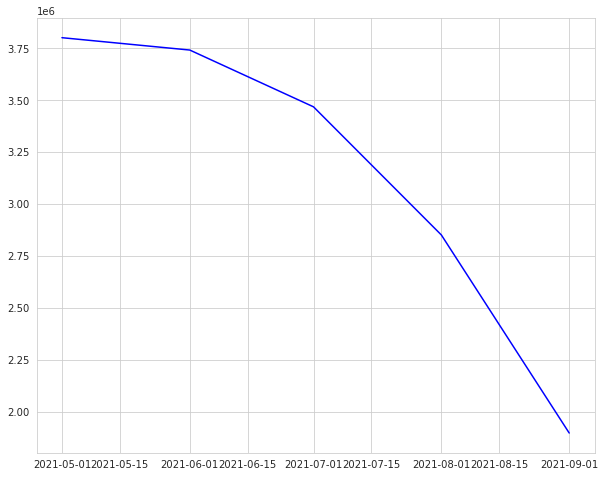

In [28]:
y_pred_lr2 = lgb_Model.predict(df_tesx)

serie_pred = pd.DataFrame()



#serie_pred['id'] = df_train['id']
serie_pred['mes'] = pd.to_datetime(df_tesx['mes'],format='%Y%m')  
serie_pred['target_mes'] = y_pred_lr2

sp = serie_pred.groupby('mes')['target_mes'].sum()
plt.figure(figsize=((10,8)))
plt.plot(sp, color='blue')
plt.show()



In [29]:
train_21489 = df_train[df_train['id']==21489]
pred_21489 = df_tesx[df_tesx['id']==21489]

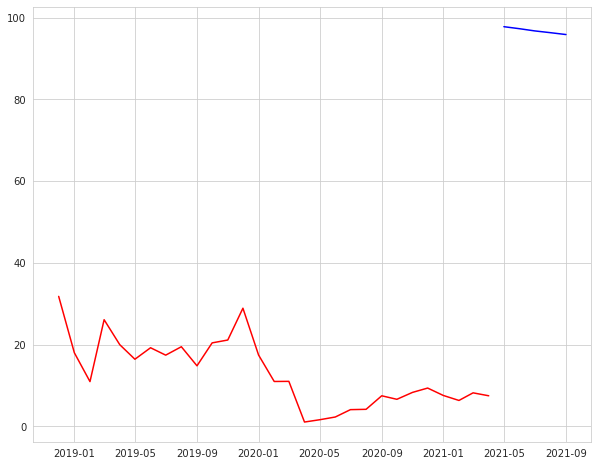

In [30]:
y_pred_lr2 = model_lr.predict(pred_21489)

serie_original = pd.DataFrame()
serie_pred = pd.DataFrame()

serie_original['mes'] = pd.to_datetime(train_21489['mes'], format='%Y%m')  
serie_original['target_mes'] = train_21489['target_mes']


serie_pred['mes'] = pd.to_datetime(pred_21489['mes'],format='%Y%m')  
serie_pred['target_mes'] = y_pred_lr2

so = serie_original.groupby('mes')['target_mes'].sum()
sp = serie_pred.groupby('mes')['target_mes'].sum()
plt.figure(figsize=((10,8)))
plt.plot(so, color = 'red')
plt.plot(sp, color='blue')
plt.show()

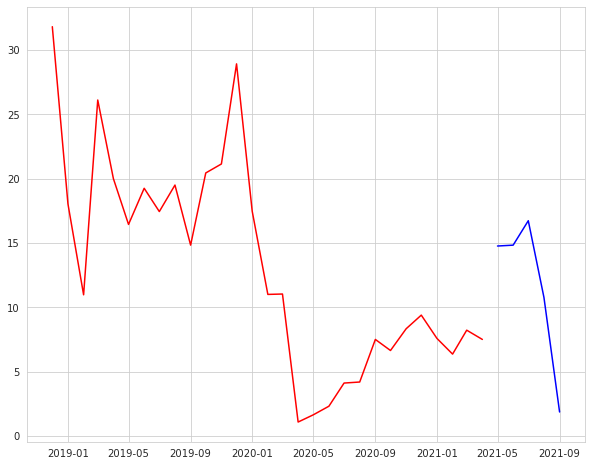

In [31]:
y_pred_lr2 = lgb_Model.predict(pred_21489)

serie_original = pd.DataFrame()
serie_pred = pd.DataFrame()

serie_original['mes'] = pd.to_datetime(train_21489['mes'], format='%Y%m')  
serie_original['target_mes'] = train_21489['target_mes']


#serie_pred['id'] = df_train['id']
serie_pred['mes'] = pd.to_datetime(pred_21489['mes'],format='%Y%m')  
serie_pred['target_mes'] = y_pred_lr2

so = serie_original.groupby('mes')['target_mes'].sum()
sp = serie_pred.groupby('mes')['target_mes'].sum()
plt.figure(figsize=((10,8)))
plt.plot(so, color = 'red')
plt.plot(sp, color='blue')
plt.show()